In [1]:
import math
import numpy as np
import scipy as sp
import numpy.random as npr  
import scipy.stats as scs
import matplotlib.pyplot as plt
import numpy.random as npr
import pandas as pd
import seaborn as sns
import statistics

In [2]:
# SVCJ parameters
mu      = 0.042
r       = mu
mu_y    = -0.0492
sigma_y = 2.061
l       = 0.0515
alpha   = 0.0102
beta    = -0.188
rho     = 0.275
sigma_v = 0.007
rho_j   = 0 #-0.210
mu_v    = 0.709
#mu_y    = np.exp(mu_y +(sigma_y**2)/2)/(1-rho_j*mu_v) -1
v0      = 0.19**2 
kappa   = 1-beta
theta   = alpha / kappa

In [3]:
npr.seed(12345)
dt      = 1/90.0 # dt
m       = int(90.0 * (1/dt)/90.0) # time horizon in days
n       = 100000

#for trials
#dt = 1/10
#n= 1000
#m = int(10*(1/dt)/10)

In [4]:
T      = m * dt
t      = np.arange(0,T+dt, dt)

In [5]:
w      = npr.standard_normal([n,m])
w2     = rho * w + sp.sqrt(1-rho**2) * npr.standard_normal([n,m])
z_v    = npr.exponential(mu_v, [n,m])
z_y    = npr.standard_normal([n,m]) * sigma_y + mu_y + rho_j * z_v
dj     = npr.binomial(1, l * dt, size=[n,m])
s      = np.zeros([n,m+1])
v      = np.zeros([n,m+1])

In [6]:
s0     = 6500
k      = 6500*0.95
s[:,0] = s0 # initial CRIX level, p. 20
v[:,0] = v0

In [7]:
for i in range(1,m+1):
    v[:,i] = v[:,i-1] + kappa * (theta - np.maximum(0,v[:,i-1])) * dt + sigma_v * sp.sqrt(np.maximum(0,v[:,i-1])) * w2[:,i-1] + z_v[:,i-1] * dj[:,i-1]
    s[:,i] = s[:,i-1] * (1 + (r - l * (mu_y + rho_j * mu_v)) * dt + sp.sqrt(v[:,i-1] * dt) * w[:,i-1]) + z_v[:,i-1] * dj[:,i-1]

In [8]:
#np.savetxt('assetapths90.csv', s,delimiter=",")

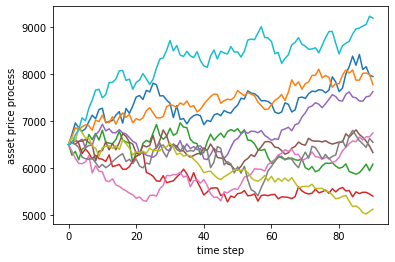

In [9]:
plt.plot(np.transpose(s[20:30]));
plt.xlabel('time step')
plt.ylabel('asset price process')
plt.savefig('assetpath90.png',transparent=T)

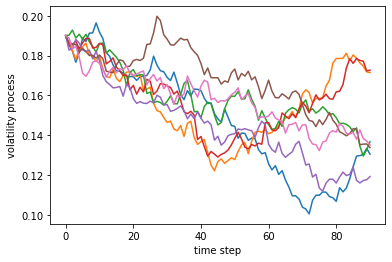

In [10]:
plt.plot(np.transpose(sp.sqrt(v[:7])));
plt.xlabel('time step')
plt.ylabel('volatility process')
plt.savefig('volatilitypath90.png',transparent=T)

In [11]:
# Option pricing 
cp    = np.exp(-mu * m * dt) * np.maximum(s[:,-1]-k,0).mean()
cp


785.8489409540293

In [12]:
def callprice(S,K,T,sigma,r):
    d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
    d2 = (sp.log(S/K) + (r - 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
    return S*scs.norm.cdf(d1) - sp.exp(-r *T) * K * scs.norm.cdf(d2)


In [13]:
#greeks

def deltafunc(S, K, T, sigma, r):
    d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
    return scs.norm.cdf(d1) 

def gamma(S, K, T, sigma, r):
    d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
    return scs.norm.pdf(d1) / (S * sigma * sp.sqrt(T))

def vega(S, K, T, sigma, r):
    d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
    return S * sp.sqrt(T) * scs.norm.pdf(d1)

In [14]:
#Hedge 

bscall  = np.zeros([n,m])
deltabs = np.zeros([n,m])
ttm     = np.arange(1, m+1, 1)/m


impliedvol = 0.287

In [15]:
# Hedging 

bscall[:,0]     = callprice(s0, k, T, impliedvol, mu)
deltabs[:,0]    = deltafunc(s0, k, T, impliedvol, mu)

In [16]:
for i in range(1,m):
    bscall[:,i]  = callprice(s[:,i], k, T-ttm[i-1], impliedvol, mu)
    deltabs[:,i] = deltafunc(s[:,i], k, T-ttm[i-1], impliedvol, mu)

In [17]:
# Dynamic delta
t         = 0;
d         = deltabs[0,0]
s_pos     = d*s[0,0] # hedge in stock
b_pos     = cp - s_pos # borrow remainder from bank account
[cp, d, s_pos, b_pos, (s_pos + b_pos)]

b_pos0    = b_pos
s_pos0    = s_pos
d0        = d

PnL       = np.zeros(n);

# daily rebalancing

for i in range(1,m):
    ttm   = T - i*dt
    pos   = d * s[:,i] + b_pos * np.exp(r*dt) # current position value
    d     = deltabs[:,i] # new delta
    s_pos = d * s[:,i]
    b_pos = pos - s_pos # make strategy self-financing any surplus or funds needed go through the bank account
    # final day / payoff
    
PnL       = (- np.maximum(s[:,-1]-6500,0) + d * s[:,i] + b_pos * np.exp(r*dt))/cp

In [18]:
np.savetxt('PnL'+str(m), PnL,delimiter=",")

In [19]:
PnL.shape

(100000,)

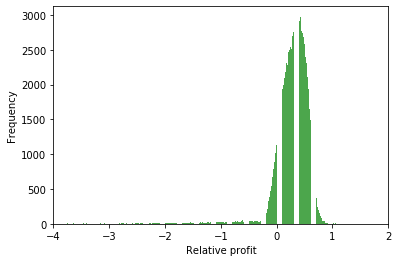

In [20]:
c, bins, patches = plt.hist(x=PnL, bins=1000, color='g',alpha=0.7, rwidth=0.7)
plt.xlabel('Relative profit')
plt.ylabel('Frequency')
#plt.title('Black Scholes Delta Hedge Relative Profit and Loss for a spot of 6500 and a strike of 6500')
maxfreq = c.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.xlim(xmin = -4, xmax=2)
plt.savefig('PnLBSDeltaHedgeATMPNL3mMA1000bin',transparent=T)
plt.show()

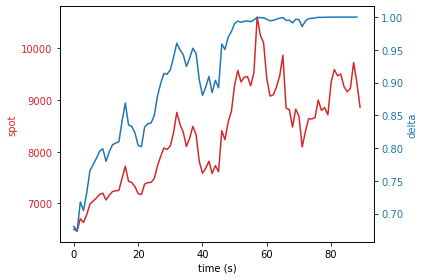

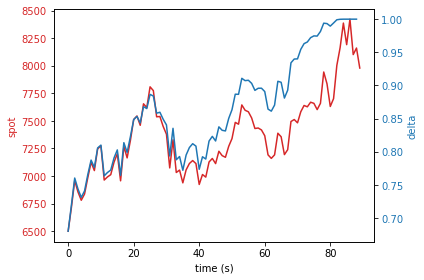

In [21]:
def plot(output, i):

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('spot', color=color)
    ax1.plot(s[i,0:-1], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('delta', color=color)  # we already handled the x-label with ax1
    ax2.plot(output[i,0:-1], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
plot(deltabs,1000)
plot(deltabs,20)

In [22]:
hedgeerror = [100*statistics.stdev(PnL)/cp]
hedgeerror

[0.05127360611306196]

In [23]:
a = np.array(PnL) 
quantile = [0.001, 0.01, 0.05,0.1,0.25,0.50,0.75,0.90,0.95, 0.99,0.999]
quantilesBS90 = np.zeros(len(quantile))
for i in range(len(quantile)):
    quantilesBS90[i] = np.quantile(a,quantile[i])
quantilesBS90

array([-4.06909589e+00, -1.42956949e+00, -9.88671554e-02,  9.27726897e-04,
        1.50656402e-01,  3.20319648e-01,  4.66755606e-01,  5.74235672e-01,
        6.32408451e-01,  7.37189194e-01,  1.21642184e+00])

In [24]:
BS90 = [round(x,3) for x in list(quantilesBS90)]

In [25]:
std90 = round(statistics.stdev(PnL),3)
skew  = round(scs.skew(PnL),3)
kurt  = round(scs.kurtosis(PnL),3)

In [26]:
[std90, 
skew,  
kurt] 

[0.403, -5.595, 64.799]